Epoch 1/100, Loss: 0.02961
Epoch 2/100, Loss: 0.01773
Epoch 3/100, Loss: 0.01497
Epoch 4/100, Loss: 0.01423
Epoch 5/100, Loss: 0.01428
Epoch 6/100, Loss: 0.01365
Epoch 7/100, Loss: 0.01329
Epoch 8/100, Loss: 0.01308
Epoch 9/100, Loss: 0.01285
Epoch 10/100, Loss: 0.01276
Epoch 11/100, Loss: 0.01291
Epoch 12/100, Loss: 0.01318
Epoch 13/100, Loss: 0.01296
Epoch 14/100, Loss: 0.01311
Epoch 15/100, Loss: 0.01291
Epoch 16/100, Loss: 0.01302
Epoch 17/100, Loss: 0.01283
Epoch 18/100, Loss: 0.01273
Epoch 19/100, Loss: 0.01299
Epoch 20/100, Loss: 0.01311
Epoch 21/100, Loss: 0.01274
Epoch 22/100, Loss: 0.01267
Epoch 23/100, Loss: 0.01295
Epoch 24/100, Loss: 0.01238
Epoch 25/100, Loss: 0.01236
Epoch 26/100, Loss: 0.01241
Epoch 27/100, Loss: 0.01243
Epoch 28/100, Loss: 0.01238
Epoch 29/100, Loss: 0.01253
Epoch 30/100, Loss: 0.01291
Epoch 31/100, Loss: 0.01237
Epoch 32/100, Loss: 0.01236
Epoch 33/100, Loss: 0.01245
Epoch 34/100, Loss: 0.01253
Epoch 35/100, Loss: 0.01221
Epoch 36/100, Loss: 0.01217
E

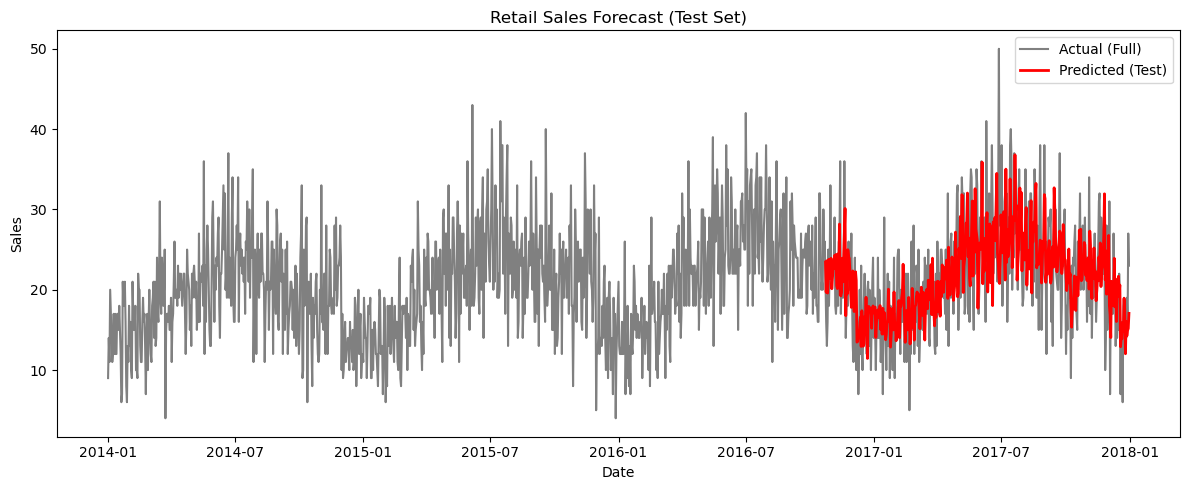

In [7]:
# ─── Imports ─────────────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
import time
import psutil
import os

# ─── Load Dataset ────────────────────────────────────────────────────────────────
file_path = r"C:\Users\diand\OneDrive - SUNTECH S.A\Desktop\Machine Learning and Predictive Modeling\Final Assignment\Retail.csv"
df = pd.read_csv(file_path)

# ─── Preprocessing ───────────────────────────────────────────────────────────────
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')  # Correct format!
df = df[['date', 'sales']].dropna()
df = df[df['sales'] >= 0].sort_values('date').reset_index(drop=True)

scaler = MinMaxScaler()
df['ScaledSales'] = scaler.fit_transform(df[['sales']])

# ─── Create Sequences ────────────────────────────────────────────────────────────
SEQ_LEN = 12
def create_sequences(series, seq_len):
    X, y = [], []
    for i in range(len(series) - seq_len):
        X.append(series[i:i+seq_len])
        y.append(series[i+seq_len])
    return np.array(X), np.array(y)

X_np, y_np = create_sequences(df['ScaledSales'].values, SEQ_LEN)
X = torch.tensor(X_np, dtype=torch.float32).unsqueeze(1)
y = torch.tensor(y_np, dtype=torch.float32)

# ─── Train-Test Split ────────────────────────────────────────────────────────────
split_idx = int(0.7 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# ─── Define TCN Components ───────────────────────────────────────────────────────
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size
    def forward(self, x):
        return x[:, :, :-self.chomp_size]

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super().__init__()
        padding = (kernel_size - 1) * dilation
        self.net = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding, dilation=dilation),
            Chomp1d(padding),
            nn.ReLU(),
            nn.Conv1d(out_channels, out_channels, kernel_size, padding=padding, dilation=dilation),
            Chomp1d(padding),
            nn.ReLU()
        )
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.relu = nn.ReLU()
    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size=3):
        super().__init__()
        layers = []
        for i in range(len(num_channels)):
            in_ch = input_size if i == 0 else num_channels[i - 1]
            out_ch = num_channels[i]
            dilation = 2 ** i
            layers.append(TemporalBlock(in_ch, out_ch, kernel_size, dilation))
        self.network = nn.Sequential(*layers)
        self.linear = nn.Linear(num_channels[-1], output_size)
    def forward(self, x):
        y = self.network(x)
        return self.linear(y[:, :, -1])

# ─── Train Model ─────────────────────────────────────────────────────────────────
def get_memory_usage():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / (1024 * 1024)  # MB

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TCN(input_size=1, output_size=1, num_channels=[16, 32, 32, 32]).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
EPOCHS = 100
BATCH_SIZE = 16
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)

start_time = time.time()
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb).squeeze()
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss/len(train_loader):.5f}")

print(f"\nTraining Time: {round(time.time() - start_time, 2)} sec | Memory: {round(get_memory_usage(), 2)} MB")

# ─── Predict on Test Set ─────────────────────────────────────────────────────────
model.eval()
with torch.no_grad():
    test_preds = model(X_test.to(device)).cpu().numpy().squeeze()

# ─── Inverse Scale Predictions ───────────────────────────────────────────────────
predicted_vals = scaler.inverse_transform(test_preds.reshape(-1, 1))[:, 0]
actual_vals = df['sales'].iloc[SEQ_LEN + split_idx:][:len(predicted_vals)].values
forecast_dates = df['date'].iloc[SEQ_LEN + split_idx:][:len(predicted_vals)].values

# ─── Plot Results ────────────────────────────────────────────────────────────────
plt.figure(figsize=(12, 5))
plt.plot(df['date'], df['sales'], label='Actual (Full)', color='gray', linewidth=1.5)
plt.plot(forecast_dates, predicted_vals, label='Predicted (Test)', color='red', linewidth=2)
plt.title('Retail Sales Forecast (Test Set)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()


In [8]:
# ─── Evaluation Metrics ──────────────────────────────────────────────────────────
mse = mean_squared_error(actual_vals, predicted_vals)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_vals, predicted_vals)
mape = np.mean(np.abs((actual_vals - predicted_vals) / actual_vals)) * 100
r2 = r2_score(actual_vals, predicted_vals)

n = len(actual_vals)   # Number of test samples
k = X.shape[1]         # Number of predictors (1 in univariate case)
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)

# ─── Print Evaluation Summary ─────────────────────────────────────────────────────
print("\nEvaluation Metrics:")
print(f"RMSE      : {rmse:.4f}")
print(f"MSE       : {mse:.4f}")
print(f"MAE       : {mae:.4f}")
print(f"MAPE      : {mape:.2f}%")
print(f"R² Score  : {r2:.4f}")
print(f"Adj. R²   : {adj_r2:.4f}")



Evaluation Metrics:
RMSE      : 5.8670
MSE       : 34.4217
MAE       : 4.7234
MAPE      : 24.67%
R² Score  : 0.2653
Adj. R²   : 0.2636
